# Deep Learning Practice: training with pretrained models

* modified from examples/02-fine-tuning.ipynb
* 2016 April 15, Heo, Min-Oh

## 1. Introduction

Model Zoo
   *  http://caffe.berkeleyvision.org/model_zoo.html
   * https://github.com/BVLC/caffe/wiki/Model-Zo


In [1]:
import caffe
caffe.set_mode_cpu()

import os
import numpy as np
from pylab import *
%matplotlib inline
import tempfile

# Helper function for deprocessing preprocessed images, e.g., for display.
def deprocess_net_image(image):
    image = image.copy()              # don't modify destructively
    image = image[::-1]               # BGR -> RGB
    image = image.transpose(1, 2, 0)  # CHW -> HWC
    image += [123, 117, 104]          # (approximately) undo mean subtraction

    # clamp values in [0, 255]
    image[image < 0], image[image > 255] = 0, 255

    # round and cast from float32 to uint8
    image = np.round(image)
    image = np.require(image, dtype=np.uint8)

    return image

/opt/caffe/python/caffe/pycaffe.py:13: RuntimeWarning: to-Python converter for boost::shared_ptr<caffe::Net<float> > already registered; second conversion method ignored.
  from ._caffe import Net, SGDSolver, NesterovSolver, AdaGradSolver, \
/opt/caffe/python/caffe/pycaffe.py:13: RuntimeWarning: to-Python converter for boost::shared_ptr<caffe::Blob<float> > already registered; second conversion method ignored.
  from ._caffe import Net, SGDSolver, NesterovSolver, AdaGradSolver, \
/opt/caffe/python/caffe/pycaffe.py:13: RuntimeWarning: to-Python converter for boost::shared_ptr<caffe::Solver<float> > already registered; second conversion method ignored.
  from ._caffe import Net, SGDSolver, NesterovSolver, AdaGradSolver, \


## 1. Setup and dataset download

### Pretrained Model: caffenet (we got already in the previous practice)
### New small dataset: style-labeled from Flickr (2000 images from 80K images, from 5 of the 20 style categories)


Download data required for this exercise.

- `get_ilsvrc_aux.sh` to download the ImageNet data mean, labels, etc.
- `download_model_binary.py` to download the pretrained reference model
- `finetune_flickr_style/assemble_data.py` download the style training and testing data

In [2]:
# Download just a small subset of the data for this exercise.
# (2000 of 80K images, 5 of 20 labels.)
# To download the entire dataset, set `full_dataset = True`.
full_dataset = False
if full_dataset:
    NUM_STYLE_IMAGES = NUM_STYLE_LABELS = -1
else:
    NUM_STYLE_IMAGES = 2000
    NUM_STYLE_LABELS = 5 

# download 2000 images from imagenet DB
# data/flickr_style/images/*.jpg
# !python examples/finetune_flickr_style/assemble_data.py --workers=7  --seed=1701 --images=$NUM_STYLE_IMAGES  --label=$NUM_STYLE_LABELS

In [3]:
# This downloads the ilsvrc auxiliary data (mean file, etc),
# and a subset of 2000 images for the style recognition task.
# !data/ilsvrc12/get_ilsvrc_aux.sh

# download pretrained model
# !scripts/download_model_binary.py models/bvlc_reference_caffenet

Define `weights`, the path to the ImageNet pretrained weights we just downloaded, and make sure it exists.

Load the 1000 ImageNet labels from `ilsvrc12/synset_words.txt`, and the 5 style labels from `finetune_flickr_style/style_names.txt`.

In [4]:
weights = 'models/bvlc_reference_caffenet/bvlc_reference_caffenet.caffemodel'

# Load ImageNet labels to imagenet_labels
imagenet_label_file = 'data/ilsvrc12/synset_words.txt'
imagenet_labels = list(np.loadtxt(imagenet_label_file, str, delimiter='\t'))
assert len(imagenet_labels) == 1000
print 'Loaded ImageNet labels:\n', '\n'.join(imagenet_labels[:10] + ['...'])

# Load style labels to style_labels
style_label_file = 'examples/finetune_flickr_style/style_names.txt'
style_labels = list(np.loadtxt(style_label_file, str, delimiter='\n'))
if NUM_STYLE_LABELS > 0:
    style_labels = style_labels[:NUM_STYLE_LABELS]
print '\nLoaded style labels:\n', ', '.join(style_labels)

Loaded ImageNet labels:
n01440764 tench, Tinca tinca
n01443537 goldfish, Carassius auratus
n01484850 great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias
n01491361 tiger shark, Galeocerdo cuvieri
n01494475 hammerhead, hammerhead shark
n01496331 electric ray, crampfish, numbfish, torpedo
n01498041 stingray
n01514668 cock
n01514859 hen
n01518878 ostrich, Struthio camelus
...

Loaded style labels:
Detailed, Pastel, Melancholy, Noir, HDR


### 2.  Defining and running the nets

Defining `caffenet`: specifying the data and number of output classes as arguments

In [5]:
from caffe import layers as L
from caffe import params as P

weight_param = dict(lr_mult=1, decay_mult=1)
bias_param   = dict(lr_mult=2, decay_mult=0)
learned_param = [weight_param, bias_param]

frozen_param = [dict(lr_mult=0)] * 2

def conv_relu(bottom, ks, nout, stride=1, pad=0, group=1,
              param=learned_param,
              weight_filler=dict(type='gaussian', std=0.01),
              bias_filler=dict(type='constant', value=0.1)):
    conv = L.Convolution(bottom, kernel_size=ks, stride=stride,
                         num_output=nout, pad=pad, group=group,
                         param=param, weight_filler=weight_filler,
                         bias_filler=bias_filler)
    return conv, L.ReLU(conv, in_place=True)

def fc_relu(bottom, nout, param=learned_param,
            weight_filler=dict(type='gaussian', std=0.005),
            bias_filler=dict(type='constant', value=0.1)):
    fc = L.InnerProduct(bottom, num_output=nout, param=param,
                        weight_filler=weight_filler,
                        bias_filler=bias_filler)
    return fc, L.ReLU(fc, in_place=True)

def max_pool(bottom, ks, stride=1):
    return L.Pooling(bottom, pool=P.Pooling.MAX, kernel_size=ks, stride=stride)

def caffenet(data, label=None, train=True, num_classes=1000,
             classifier_name='fc8', learn_all=False):
    """Returns a NetSpec specifying CaffeNet, following the original proto text
       specification (./models/bvlc_reference_caffenet/train_val.prototxt)."""
    n = caffe.NetSpec()
    n.data = data
    param = learned_param if learn_all else frozen_param
    n.conv1, n.relu1 = conv_relu(n.data, 11, 96, stride=4, param=param)
    n.pool1 = max_pool(n.relu1, 3, stride=2)
    n.norm1 = L.LRN(n.pool1, local_size=5, alpha=1e-4, beta=0.75)
    n.conv2, n.relu2 = conv_relu(n.norm1, 5, 256, pad=2, group=2, param=param)
    n.pool2 = max_pool(n.relu2, 3, stride=2)
    n.norm2 = L.LRN(n.pool2, local_size=5, alpha=1e-4, beta=0.75)
    n.conv3, n.relu3 = conv_relu(n.norm2, 3, 384, pad=1, param=param)
    n.conv4, n.relu4 = conv_relu(n.relu3, 3, 384, pad=1, group=2, param=param)
    n.conv5, n.relu5 = conv_relu(n.relu4, 3, 256, pad=1, group=2, param=param)
    n.pool5 = max_pool(n.relu5, 3, stride=2)
    n.fc6, n.relu6 = fc_relu(n.pool5, 4096, param=param)
    if train:
        n.drop6 = fc7input = L.Dropout(n.relu6, in_place=True)
    else:
        fc7input = n.relu6
    n.fc7, n.relu7 = fc_relu(fc7input, 4096, param=param)
    if train:
        n.drop7 = fc8input = L.Dropout(n.relu7, in_place=True)
    else:
        fc8input = n.relu7
    # always learn fc8 (param=learned_param)
    fc8 = L.InnerProduct(fc8input, num_output=num_classes, param=learned_param)
    # give fc8 the name specified by argument `classifier_name`
    n.__setattr__(classifier_name, fc8)
    if not train:
        n.probs = L.Softmax(fc8)
    if label is not None:
        n.label = label
        n.loss = L.SoftmaxWithLoss(fc8, n.label)
        n.acc = L.Accuracy(fc8, n.label)
    # write the net to a temporary file and return its filename
    with tempfile.NamedTemporaryFile(delete=False) as f:
        f.write(str(n.to_proto()))
        return f.name

Creating a *CaffeNet*  with unlabeled "dummy data" as input 
- to give input images externally, 
- to see what ImageNet classes it predicts.

In [6]:
dummy_data = L.DummyData(shape=dict(dim=[1, 3, 227, 227]))
imagenet_net_filename = caffenet(data=dummy_data, train=False)
imagenet_net = caffe.Net(imagenet_net_filename, weights, caffe.TEST)

Defining `style_net`: modified `caffenet` on the Flickr style dataset

The differences in the input and output:

    - Input:  the Flickr style data we downloaded, provided by an `ImageData` layer
    - Output: only 20 style classes ( original ImageNet has 1000 classes )
    - classification layer: renamed from `fc8` to `fc8_flickr`  (`fc8` weights will Not loaded from the ImageNet-pretrained model)

In [7]:
def style_net(train=True, learn_all=False, subset=None):
    if subset is None:
        subset = 'train' if train else 'test'
    source = 'data/flickr_style/%s.txt' % subset
    transform_param = dict(mirror=train, crop_size=227, mean_file= 'data/ilsvrc12/imagenet_mean.binaryproto')
    style_data, style_label = L.ImageData(
        transform_param=transform_param, source=source,
        batch_size=50, new_height=256, new_width=256, ntop=2)
    return caffenet(data=style_data, label=style_label, train=train,
                    num_classes=NUM_STYLE_LABELS, classifier_name='fc8_flickr', learn_all=learn_all)

Building `untrained_style_net` (using the pretrained model except fc8_flickr layer, and this layer will Not trained)


In [8]:
untrained_style_net = caffe.Net(style_net(train=False, subset='train'),
                                weights, caffe.TEST)
untrained_style_net.forward()

style_data_batch = untrained_style_net.blobs['data'].data.copy()
style_label_batch = np.array(untrained_style_net.blobs['label'].data, dtype=np.int32)

Check the result with one input example 

In [9]:
def disp_preds(net, image, labels, k=5, name='ImageNet'):
    input_blob = net.blobs['data']
    net.blobs['data'].data[0, ...] = image
    probs = net.forward(start='conv1')['probs'][0]
    top_k = (-probs).argsort()[:k]
    print 'top %d predicted %s labels =' % (k, name)
    print '\n'.join('\t(%d) %5.2f%% %s' % (i+1, 100*probs[p], labels[p])
                    for i, p in enumerate(top_k))

def disp_imagenet_preds(net, image):
    disp_preds(net, image, imagenet_labels, name='ImageNet')

def disp_style_preds(net, image):
    disp_preds(net, image, style_labels, name='style')

actual label = Melancholy


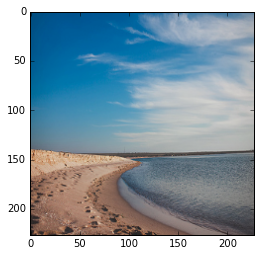

In [10]:
batch_index = 8
image = style_data_batch[batch_index]
plt.imshow(deprocess_net_image(image))
print 'actual label =', style_labels[style_label_batch[batch_index]]

In [11]:
disp_imagenet_preds(imagenet_net, image)

top 5 predicted ImageNet labels =
	(1) 69.89% n09421951 sandbar, sand bar
	(2) 21.75% n09428293 seashore, coast, seacoast, sea-coast
	(3)  3.22% n02894605 breakwater, groin, groyne, mole, bulwark, seawall, jetty
	(4)  1.89% n04592741 wing
	(5)  1.23% n09332890 lakeside, lakeshore


In [12]:
disp_style_preds(untrained_style_net, image)

top 5 predicted style labels =
	(1) 20.00% Detailed
	(2) 20.00% Pastel
	(3) 20.00% Melancholy
	(4) 20.00% Noir
	(5) 20.00% HDR


In [13]:
diff = untrained_style_net.blobs['fc7'].data[0] - imagenet_net.blobs['fc7'].data[0]
error = (diff ** 2).sum()
assert error < 1e-8

In [14]:
del untrained_style_net, imagenet_net

### 3. Training the style classifier

Over the same architecture, the only final upper layer *fc8*  will be trained  in this part

In [15]:
from caffe.proto import caffe_pb2

def solver(train_net_path, test_net_path=None, base_lr=0.001):
    s = caffe_pb2.SolverParameter()

    # Specify locations of the train and (maybe) test networks.
    s.train_net = train_net_path
    if test_net_path is not None:
        s.test_net.append(test_net_path)
        s.test_interval = 1000  # Test after every 1000 training iterations.
        s.test_iter.append(100) # Test on 100 batches each time we test.

    # The number of iterations over which to average the gradient.
    # Effectively boosts the training batch size by the given factor, without
    # affecting memory utilization.
    s.iter_size = 1
    
    s.max_iter = 100000     # # of times to update the net (training iterations)
    
    # Solve using the stochastic gradient descent (SGD) algorithm.
    # Other choices include 'Adam' and 'RMSProp'.
    s.type = 'SGD'

    # Set the initial learning rate for SGD.
    s.base_lr = base_lr

    # Set `lr_policy` to define how the learning rate changes during training.
    # Here, we 'step' the learning rate by multiplying it by a factor `gamma`
    # every `stepsize` iterations.
    s.lr_policy = 'step'
    s.gamma = 0.1
    s.stepsize = 20000

    # Set other SGD hyperparameters. Setting a non-zero `momentum` takes a
    # weighted average of the current gradient and previous gradients to make
    # learning more stable. L2 weight decay regularizes learning, to help prevent
    # the model from overfitting.
    s.momentum = 0.9
    s.weight_decay = 5e-4

    # Display the current training loss and accuracy every 1000 iterations.
    s.display = 1000

    # Snapshots are files used to store networks we've trained.  Here, we'll
    # snapshot every 10K iterations -- ten times during training.
    s.snapshot = 10000
    s.snapshot_prefix = 'models/finetune_flickr_style/finetune_flickr_style'
    
    # Using the CPU to train large networks is very slow.
    s.solver_mode = caffe_pb2.SolverParameter.CPU
    
    # Write the solver to a temporary file and return its filename.
    with tempfile.NamedTemporaryFile(delete=False) as f:
        f.write(str(s))
        return f.name

run Solver.

You may use Command Line Interface (CLI): see the slide for the command

In the original example, this function that takes a list of solvers and steps each one in a round robin manner, recording the accuracy and loss values each iteration.  At the end, the learned weights are saved to a file.

But, to run this example on the docker over Windows, the below function *run_solvers* will train one by one.

In [16]:
def run_solvers(niter, solvers, disp_interval=10):
    """Run solvers for niter iterations,
       returning the loss and accuracy recorded each iteration.
       `solvers` is a list of (name, solver) tuples."""
    blobs = ('loss', 'acc')
    loss, acc = ({name: np.zeros(niter) for name, _ in solvers}
                 for _ in blobs)
    for it in range(niter):
        for name, s in solvers:
            s.step(1)  # run a single SGD step in Caffe
            loss[name][it], acc[name][it] = (s.net.blobs[b].data.copy()
                                             for b in blobs)
        if it % disp_interval == 0 or it + 1 == niter:
            loss_disp = '; '.join('%s: loss=%.3f, acc=%2d%%' %
                                  (n, loss[n][it], np.round(100*acc[n][it]))
                                  for n, _ in solvers)
            print '%3d) %s' % (it, loss_disp)     
    # Save the learned weights from both nets.
    weight_dir = tempfile.mkdtemp()
    weights = {}
    for name, s in solvers:
        filename = 'weights.%s.caffemodel' % name
        weights[name] = os.path.join(weight_dir, filename)
        s.net.save(weights[name])
    return loss, acc, weights

To compare the effect of pretrained models, 
2 solvers will be tested 
* 1) `style_solver`
* 2) `scratch_style_solver`: train starting with random initialized weightes 

In [17]:
niter = 200  # number of iterations to train

# Reset style_solver as before.
style_solver_filename = solver(style_net(train=True))
style_solver = caffe.get_solver(style_solver_filename)
style_solver.net.copy_from(weights)

print 'Running solvers for %d iterations...' % niter
solvers = [('pretrained', style_solver)]           
loss, acc, weights = run_solvers(niter, solvers)
print 'Done.'

train_loss = loss['pretrained']
train_acc = acc['pretrained']
style_weights = weights['pretrained']

# Delete solvers to save memory.
del style_solver, solvers

Running solvers for 200 iterations...
  0) pretrained: loss=1.609, acc=28%
 10) pretrained: loss=1.350, acc=48%
 20) pretrained: loss=1.220, acc=42%
 30) pretrained: loss=0.850, acc=64%
 40) pretrained: loss=0.932, acc=58%
 50) pretrained: loss=1.108, acc=64%
 60) pretrained: loss=0.915, acc=58%
 70) pretrained: loss=0.971, acc=62%
 80) pretrained: loss=0.856, acc=66%
 90) pretrained: loss=1.208, acc=50%
100) pretrained: loss=0.950, acc=74%
110) pretrained: loss=0.894, acc=66%
120) pretrained: loss=1.060, acc=58%
130) pretrained: loss=0.946, acc=66%
140) pretrained: loss=0.939, acc=68%
150) pretrained: loss=0.539, acc=82%
160) pretrained: loss=0.941, acc=62%
170) pretrained: loss=1.189, acc=58%
180) pretrained: loss=0.785, acc=64%
190) pretrained: loss=0.868, acc=66%
199) pretrained: loss=0.665, acc=70%
Done.


In [18]:
# For reference, we also create a solver that isn't initialized from
# the pretrained ImageNet weights.
scratch_style_solver_filename = solver(style_net(train=True))
scratch_style_solver = caffe.get_solver(scratch_style_solver_filename)

print 'Running solvers for %d iterations...' % niter
solvers = [('scratch', scratch_style_solver)]
loss, acc, weights = run_solvers(niter, solvers)
print 'Done.'

scratch_train_loss = loss['scratch']
scratch_train_acc = acc['scratch']
scratch_style_weights = weights['scratch']

# Delete solvers to save memory.
del scratch_style_solver, solvers

Running solvers for 200 iterations...
  0) scratch: loss=1.609, acc=28%
 10) scratch: loss=1.627, acc=14%
 20) scratch: loss=1.642, acc=12%
 30) scratch: loss=1.616, acc=22%
 40) scratch: loss=1.592, acc=24%
 50) scratch: loss=1.609, acc=32%
 60) scratch: loss=1.622, acc=16%
 70) scratch: loss=1.588, acc=30%
 80) scratch: loss=1.593, acc=34%
 90) scratch: loss=1.606, acc=24%
100) scratch: loss=1.588, acc=30%
110) scratch: loss=1.590, acc=30%
120) scratch: loss=1.593, acc=26%
130) scratch: loss=1.588, acc=28%
140) scratch: loss=1.610, acc=18%
150) scratch: loss=1.611, acc=20%
160) scratch: loss=1.600, acc=26%
170) scratch: loss=1.623, acc=20%
180) scratch: loss=1.634, acc=10%
190) scratch: loss=1.607, acc=20%
199) scratch: loss=1.618, acc=14%
Done.


* Blue: the ImageNet pretrained model's loss (Pretrained)
* Green: the randomly initialized model's loss (Scratch)

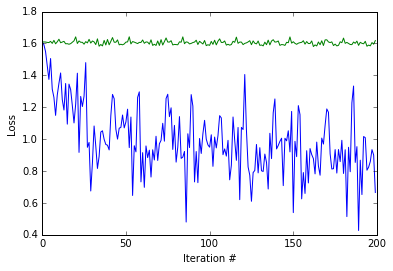

In [19]:
plot(np.vstack([train_loss, scratch_train_loss]).T)
xlabel('Iteration #')
ylabel('Loss')

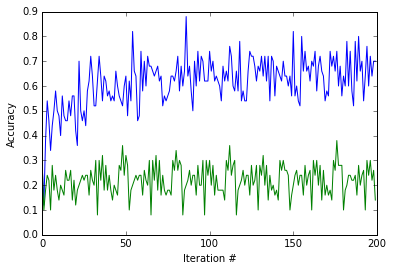

In [20]:
plot(np.vstack([train_acc, scratch_train_acc]).T)
xlabel('Iteration #')
ylabel('Accuracy')

In [21]:
def eval_style_net(weights, test_iters=10):
    test_net = caffe.Net(style_net(train=False), weights, caffe.TEST)
    accuracy = 0
    for it in xrange(test_iters):
        accuracy += test_net.forward()['acc']
    accuracy /= test_iters
    return test_net, accuracy

In [22]:
test_net, accuracy = eval_style_net(style_weights)
print 'Accuracy, trained from ImageNet initialization: %3.1f%%' % (100*accuracy, )

Accuracy, trained from ImageNet initialization: 51.0%


In [23]:
del test_net

In [24]:
scratch_test_net, scratch_accuracy = eval_style_net(scratch_style_weights)
print 'Accuracy, trained from   random initialization: %3.1f%%' % (100*scratch_accuracy, )

Accuracy, trained from   random initialization: 23.6%


In [25]:
del scratch_test_net

### 4. End-to-end finetuning for style

All layers will be opened to train

To control whether learns all layers with argument 'learn_all'

We pass the argument `learn_all=True` to the `style_net` function defined earlier in this notebook, which tells the function to apply a positive (non-zero) `lr_mult` value for all parameters.  

Under the default, `learn_all=False`, all parameters in the pretrained layers (`conv1` through `fc7`) are frozen (`lr_mult = 0`), and we learn only the classifier layer `fc8_flickr`.

* Note: both networks start at roughly the accuracy achieved at the end of the previous training session, and improve significantly with end-to-end training.  

In [26]:
end_to_end_net = style_net(train=True, learn_all=True)

# Set base_lr to 1e-3, the same as last time when learning only the classifier.
# You may want to play around with different values of this or other
# optimization parameters when fine-tuning.  For example, if learning diverges
# (e.g., the loss gets very large or goes to infinity/NaN), you should try
# decreasing base_lr (e.g., to 1e-4, then 1e-5, etc., until you find a value
# for which learning does not diverge).
base_lr = 0.001

style_solver_filename = solver(end_to_end_net, base_lr=base_lr)
style_solver = caffe.get_solver(style_solver_filename)
style_solver.net.copy_from(style_weights)


print 'Running solvers for %d iterations...' % niter
solvers = [('pretrained, end-to-end', style_solver)]
_, _, finetuned_weights = run_solvers(niter, solvers)
print 'Done.'

style_weights_ft = finetuned_weights['pretrained, end-to-end']

# Delete solvers to save memory.
del style_solver, solvers

Running solvers for 200 iterations...
  0) pretrained, end-to-end: loss=0.687, acc=76%
 10) pretrained, end-to-end: loss=1.302, acc=56%
 20) pretrained, end-to-end: loss=0.807, acc=70%
 30) pretrained, end-to-end: loss=0.993, acc=70%
 40) pretrained, end-to-end: loss=0.793, acc=64%
 50) pretrained, end-to-end: loss=0.899, acc=72%
 60) pretrained, end-to-end: loss=0.682, acc=78%
 70) pretrained, end-to-end: loss=0.534, acc=80%
 80) pretrained, end-to-end: loss=0.533, acc=80%
 90) pretrained, end-to-end: loss=0.830, acc=72%
100) pretrained, end-to-end: loss=0.513, acc=76%
110) pretrained, end-to-end: loss=0.474, acc=86%
120) pretrained, end-to-end: loss=0.457, acc=80%
130) pretrained, end-to-end: loss=0.488, acc=82%
140) pretrained, end-to-end: loss=0.634, acc=76%
150) pretrained, end-to-end: loss=0.374, acc=84%
160) pretrained, end-to-end: loss=0.519, acc=78%
170) pretrained, end-to-end: loss=0.507, acc=74%
180) pretrained, end-to-end: loss=0.618, acc=74%
190) pretrained, end-to-end: lo

In [27]:
scratch_style_solver_filename = solver(end_to_end_net, base_lr=base_lr)
scratch_style_solver = caffe.get_solver(scratch_style_solver_filename)
scratch_style_solver.net.copy_from(scratch_style_weights)

print 'Running solvers for %d iterations...' % niter
solvers = [('scratch, end-to-end', scratch_style_solver)]
_, _, finetuned_weights = run_solvers(niter, solvers)
print 'Done.'

scratch_style_weights_ft = finetuned_weights['scratch, end-to-end']

del scratch_style_solver, solvers

Running solvers for 200 iterations...
  0) scratch, end-to-end: loss=1.586, acc=28%
 10) scratch, end-to-end: loss=1.642, acc=14%
 20) scratch, end-to-end: loss=1.632, acc=14%
 30) scratch, end-to-end: loss=1.596, acc=22%
 40) scratch, end-to-end: loss=1.579, acc=24%
 50) scratch, end-to-end: loss=1.599, acc=30%
 60) scratch, end-to-end: loss=1.566, acc=22%
 70) scratch, end-to-end: loss=1.554, acc=34%
 80) scratch, end-to-end: loss=1.508, acc=42%
 90) scratch, end-to-end: loss=1.515, acc=34%
100) scratch, end-to-end: loss=1.505, acc=30%
110) scratch, end-to-end: loss=1.601, acc=26%
120) scratch, end-to-end: loss=1.554, acc=28%
130) scratch, end-to-end: loss=1.528, acc=26%
140) scratch, end-to-end: loss=1.511, acc=34%
150) scratch, end-to-end: loss=1.489, acc=34%
160) scratch, end-to-end: loss=1.429, acc=30%
170) scratch, end-to-end: loss=1.611, acc=32%
180) scratch, end-to-end: loss=1.447, acc=40%
190) scratch, end-to-end: loss=1.411, acc=38%
199) scratch, end-to-end: loss=1.364, acc=

In [28]:
test_net, accuracy = eval_style_net(style_weights_ft)
print 'Accuracy, finetuned from ImageNet initialization: %3.1f%%' % (100*accuracy, )
scratch_test_net, scratch_accuracy = eval_style_net(scratch_style_weights_ft)
print 'Accuracy, finetuned from   random initialization: %3.1f%%' % (100*scratch_accuracy, )

Accuracy, finetuned from ImageNet initialization: 54.8%
Accuracy, finetuned from   random initialization: 40.6%


top 5 predicted style labels =
	(1) 83.04% Melancholy
	(2) 12.75% HDR
	(3)  4.09% Pastel
	(4)  0.11% Detailed
	(5)  0.01% Noir


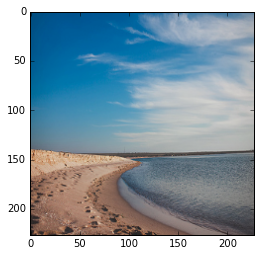

In [29]:
plt.imshow(deprocess_net_image(image))
disp_style_preds(test_net, image)

actual label = Pastel


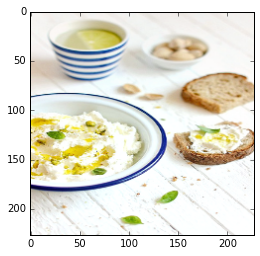

In [30]:
batch_index = 1
image = test_net.blobs['data'].data[batch_index]
plt.imshow(deprocess_net_image(image))
print 'actual label =', style_labels[int(test_net.blobs['label'].data[batch_index])]

In [31]:
disp_style_preds(test_net, image)

top 5 predicted style labels =
	(1) 99.67% Pastel
	(2)  0.20% Detailed
	(3)  0.13% HDR
	(4)  0.00% Melancholy
	(5)  0.00% Noir


In [32]:
disp_style_preds(scratch_test_net, image)

top 5 predicted style labels =
	(1) 46.91% Pastel
	(2) 19.56% Detailed
	(3) 19.48% Melancholy
	(4) 11.94% HDR
	(5)  2.12% Noir
